<a href="https://colab.research.google.com/github/Chacon-Miguel/TESS-ZTF-Light-Curve-Classifier/blob/main/simulated_data/sc_training_with_sim_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
path_to_module = '/content/drive/MyDrive/TESS-ZTF-Transient-Classification/'

import sys
import pandas as pd
import keras
import pickle
import numpy as np
from os import walk
import os
import matplotlib.pyplot as plt
import pickle as pkl
import math
import random
import keras.backend as K
import tensorflow as tf

from sys import path
from google.colab import drive, files
from collections import Counter
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras import layers, Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import (GRU, Dense, Lambda, Masking, RepeatVector, TimeDistributed, concatenate)
from keras.optimizers import adam_v2
from sklearn.manifold import TSNE
from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()
# tf.InteractiveSession()
# tf.compat.v1.enable_eager_execution()
filterwarnings("ignore")
path.append(path_to_module)
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
data = None
with open(path_to_module + 'light_curves_sims/separated_classes/numpy_files/dataset.pickle', 'rb') as file:
  data = pickle.load(file)
# data is list of numpy arrays:
# first array is light curve names
# second one is light curve labels
# third one is light curves
names, labels, dataset = data
labels = np.array(labels)

# normalize data using min-max range
for i, xarr in enumerate(dataset):
    mask = np.where(xarr[:, 2:3] != 0)[0]
    maxval = xarr[:, 2:3][mask].max()
    minval = xarr[:, 2:3][mask].min()
    dataset[i, :, 2:3][mask] = dataset[i, :, 2:3][mask] / (maxval-minval) 
    dataset[i, :, 3:4][mask] = dataset[i, :, 3:4][mask] / (maxval-minval)

In [ ]:
class CustomMasking(layers.Layer):
  def __init__(self, **kwargs):
    super(CustomMasking, self).__init__(name = "CustomMasking", **kwargs)
    # self.output_dim = output_dim
    self.supports_masking = True

  def call(self, inputs, mask = None):
    return inputs * mask

In [ ]:
class Sampling(layers.Layer):
  def __init__(self, output_dim, **kwargs):
    super(Sampling, self).__init__(name = "Sampling", **kwargs)
    self.output_dim = output_dim
    self.supports_masking = True


  def call(self, inputs, mask = None):
    # print("Sampling Output:", inputs)
    z_mean, z_log_var = inputs
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    output = z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    return output

In [ ]:
class Encoder(keras.Model):
  def __init__(self, shapes, mask_val=0, name = 'encoder', **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.mask_val = mask_val
    self.shapes = shapes

    self.enc_input = Input(shape=shapes['enc_input'])
    self.mask = Masking(mask_value=mask_val)

    # first recurrent layer
    self.gru1 = GRU(shapes['gru1'], activation='tanh', 
                    recurrent_activation='hard_sigmoid', return_sequences=True, name='gru1')
    # second recurrent layer  
    self.encoded = GRU(shapes['gru2'], activation='tanh',
                    recurrent_activation='hard_sigmoid', return_sequences=True, name='gru2')
    
    # z mean output
    self.z_mean = GRU(shapes['gru3'], return_sequences=False, activation='linear', name='gru3')

    # z variance output
    self.z_log_var = GRU(shapes['gru4'], return_sequences=False, activation='linear', name='gru4')

    # sample output
    self.z = Sampling(shapes['gru4'])

  def get_config(self):
      # config = super(Encoder, self).get_config()
      config = {"shapes": self.shapes, 'mask_val':0, 'name':'encoder'}
      return config

  # define forward pass
  def call(self, inputs):
    mask_tensor = self.mask(inputs)
    gru1        = self.gru1(inputs)
    encoded     = self.encoded(gru1)
    z_mean      = self.z_mean(encoded)
    z_log_var   = self.z_log_var(encoded)
    z           = self.z([z_mean, z_log_var])

    return z_mean, z_log_var, z

In [ ]:
class Decoder(keras.Model):
  def __init__(self, shapes, mask_val=0, name = 'decoder', **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.mask_val = mask_val
    self.shapes = shapes

    # define layers
    self.decoder_input = Input(shape=shapes['dec_input'])

    self.repeater = RepeatVector(shapes['repeater'], name='rep')

    self.mask = Masking(mask_value=0.0)

    self.custom_mask = CustomMasking()
    # time and filter ID vals
    self.input_two = Input(shape=shapes['input_two'])

    # first recurrent layer
    self.gru5 = GRU(shapes['gru5'], activation='tanh',
                    recurrent_activation='hard_sigmoid', return_sequences=True, name='gru5')
    
    # second recurrent layer
    self.gru6 = GRU(shapes['gru6'], activation='tanh',
                    recurrent_activation='hard_sigmoid', return_sequences=True, name='gru6')

    # decoder output
    self.dec_output = TimeDistributed(Dense(1, activation='tanh', input_shape=shapes['dec_output']), name='td')

  def get_config(self):
      config = {"shapes": self.shapes, 'mask_val':0, 'name':'decoder'}
      return config

  # define forward pass
  def call(self, inputs):
    z, train_input_two, masks, dec_masks = inputs
    # back at 200 numbs
    repeater = self.repeater(z)
    # original mask size was: (1, 80, 4)
    # convert this mask to (1, 80, 30) to make mask same size as output
    # of repeater

    concat = concatenate([repeater, train_input_two], axis =-1)
    # mask_tensor = self.mask.compute_mask(masks)

    mask_tensor = self.custom_mask(concat, mask=masks)

    gru5 = self.gru5(mask_tensor, mask=None)
    # print(f'gru5: {gru5}')

    gru6 = self.gru6(gru5)
    # print(f'gru6: {gru6}')

    dec_output = self.dec_output(gru6)#, mask = mask_tensor)
    # print(f'dec_output: {dec_output}')


    return self.custom_mask(dec_output, mask=dec_masks)
    # return dec_output


In [ ]:
class VAE(keras.Model):
  def __init__(self, prepared_data, dims=(16000,80,4), name='vae', **kwargs):
    super(VAE, self).__init__(name=name, **kwargs)
    self.epochs = 10
    self.batch_size = 64
    self.optimizer = 'adam'

    # dimension of the latent vector
    self.latent_dim = 30

    # input to first encoder and second decoder layer
    self.gru_one = 175

    # input to first decoder and second encoder layer
    self.gru_two = 150

    # load prepared dad (acts a input)
    self.prepared_data = np.array(prepared_data)
    
    # number of input features
    self.num_feats = dims[2]
    
    # number of timesteps
    self.num_timesteps = dims[1]

    # dimension of the input space for encoder
    self.enc_input_shape = (self.num_timesteps, self.num_feats)

    # number of light curves
    self.num_lcs = dims[0]

    # layer dimensions for encoder and decoder, respectively
    self.enc_dims = {
      'enc_input': self.enc_input_shape,
      'gru1': self.gru_one,
      'gru2': self.gru_two,
      'gru3': 30,
      'gru4': 30
    }
    self.dec_dims = {
      'dec_input': 30,
      'repeater': self.num_timesteps,
      'input_two': (self.num_timesteps, 2),
      'gru5': self.gru_two,
      'gru6': self.gru_one,
      'dec_output': (None, 1)
    }


    # indxs for test and train
    self.train_indx = set()
    self.test_indx  = set()

    self.mask_value = 0.0
    
    self.encoder = Encoder(self.enc_dims)
    self.decoder = Decoder(self.dec_dims)

  def get_config(self):
      config = {"prepared_data": np.array(self.prepared_data), 'name':'vae'}
      return config

  # define forward pass
  def call(self, inputs):
    x_train, train_input_two, masks, dec_masks = inputs
    z_mean, z_log_var, z = self.encoder(x_train)
    # print(z_mean, z_log_var, z, mask)
    reconstructed = self.decoder([z, train_input_two, masks, dec_masks])

    # Add KL divergence regularization loss.
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss)
    return reconstructed

  def reconstruction_loss(self, yTrue, yPred):
    return K.log(K.mean(K.square(yTrue - yPred)))

  def split_prep_data(self):
      """
      Splits data into 3/4 training, 1/4 testing
      """

      print("Splitting data into train and test...")

      # prepared out (only flux)
      prep_out = self.prepared_data[:, :, 2].reshape(
          self.num_lcs, self.num_timesteps, 1)
      # prep_out = self.prepared_data[:, :, 2]
      # print('prep_out shape', prep_out.shape)
      prep_inp = self.prepared_data

      x_train = []
      y_train = []
      x_test = []
      y_test = []

      # calc the # of light curves for train vs test
      num_lcs = len(prep_inp)
      train_perc = round(1.0 * num_lcs)
      test_perc = round(num_lcs*0.2)

      # save random indices for training
      while len(self.train_indx) != train_perc:
          indx = random.randint(0, num_lcs-1)
          self.train_indx.add(indx)

      # save random indices for testint -> no duplicates from training
      while len(self.test_indx) <= test_perc:
          indx = random.randint(0, num_lcs-1)
          # if indx not in self.train_indx:
          self.test_indx.add(indx)

      # extract training data
      for ind in self.train_indx:
          x_train.append(prep_inp[ind])
          y_train.append(prep_out[ind])

      # extract testing data
      for ind in self.test_indx:
          x_test.append(prep_inp[ind])
          y_test.append(prep_out[ind])

      # change to numpy arrays
      x_train = np.array(x_train).astype(np.float64)
      x_test = np.array(x_test).astype(np.float64)
      y_train = np.array(y_train).astype(np.float64)
      y_test = np.array(y_test).astype(np.float64)

      print('shape of prep_inp and x_train:', prep_inp.shape, x_train.shape)
      print('shape of prep_out and y_train:', prep_out.shape, y_train.shape)

      return x_train, x_test, y_train, y_test

  def compute_masks(self, x_train, size):
    masks = []
    for light_curve in x_train:
      mask = []
      for (time, band, flux, error) in light_curve:
        if band == 0:
          mask.append([0.0]*(size))
        else:
          mask.append([1.0]*(size))
      masks.append(mask)

    return np.array(masks)

  def train_model(self, x_train, x_test, y_train, y_test):
      """
      Trains the NN on training data

      Returns the trained model.
      """
      # fit model
      train_inp_two = x_train[:, :, :2]
      assert (train_inp_two.shape == (
          x_train.shape[0], x_train.shape[1], 2))

      test_inp_two = x_test[:, :, :2]
      assert (test_inp_two.shape == (
          x_test.shape[0], x_test.shape[1], 2))
      
      # Compute mask here
      train_masks = self.compute_masks(x_train, self.latent_dim + 2)
      test_masks  = self.compute_masks(x_test,  self.latent_dim + 2)
      train_dec_output_masks = self.compute_masks(x_train, 1)
      test_dec_output_masks =  self.compute_masks(x_test,  1)

      print('fitting model...')
      print(f'x_train shape: {x_train.shape}')
      history = self.fit([x_train, train_inp_two, train_masks, train_dec_output_masks], 
                         y_train, epochs=self.epochs, batch_size=self.batch_size,
                          validation_data=([x_test, test_inp_two, test_masks, test_dec_output_masks], y_test), verbose=1, shuffle=False)

      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()

  def test_model(self, x_test, y_test, amount = None):
      """
      Uses test data to and NN to predict light curve decodings.

      Plots reconstructed light curved from the model prediction vs the orignal curve.
      """
      if amount:
        indices = random.sample(range(len(x_test)), k=amount)
        x_test = np.array([x_test[i] for i in indices])
        y_test = np.array([y_test[i] for i in indices])
      

      test_inp_two = x_test[:, :, :2]

      print('test_inp_one shape: ', x_test.shape)
      print('test_inp_two shape: ', test_inp_two.shape)

      self.summary()

      print('predicting...')
      for i in tqdm(range(len(x_test))):

          # predicted flux
          predicted = self.predict([x_test[i].reshape(-1, self.num_timesteps, 4),
                                    test_inp_two[i].reshape(-1, self.num_timesteps, 2)])[0]

          # if first prediction, print the prediction
          if i == 0:
              print('shape of predicted data: ', predicted.shape)

          self.plot_band_pred(y_test[i], predicted, i, test_inp_two[i])

      print("done predicting")

  def plot_band_pred(self, raw, pred, num, time_filters):
      raw_g_flux    = []
      raw_r_flux    = []
      raw_tess_flux = []

      pred_g_flux    = []
      pred_r_flux    = []
      pred_tess_flux = []

      g_time    = []
      r_time    = []
      tess_time = []
      # print(time_filters)
      for i in range(len(time_filters)):
        time, filter_ID = time_filters[i]
        raw_flux  = raw[i, 0]
        pred_flux = pred[i, 0]
        if filter_ID == 4.8:
          raw_g_flux.append(raw_flux)
          pred_g_flux.append(pred_flux)
          g_time.append(time)
        elif filter_ID == 6.5:
          raw_r_flux.append(raw_flux)
          pred_r_flux.append(pred_flux)
          r_time.append(time)
        elif filter_ID == 7.9:
          raw_tess_flux.append(raw_flux)
          pred_tess_flux.append(pred_flux)
          tess_time.append(time)

      # plot
      # make 1 x 2 figure
      fig, (ax1, ax2) = plt.subplots(2, sharey = True)
      fig.suptitle('True vs Decoded Light Curves: ' )#+ str(light_curve_names[num]))

      # pred_time = range(len(pred_flux))
      # raw_time = range(len(raw_flux))

      # plot raw data
      ax1.scatter(g_time, raw_g_flux, label='g-band', color = 'green')
      ax1.scatter(r_time, raw_r_flux, label='r-band', color = 'red')
      ax1.scatter(tess_time, raw_tess_flux, label='tess-band')
      ax1.set_ylabel('actual')

      # plot predicted data
      ax2.set_ylabel('predicted')
      ax2.scatter(g_time, pred_g_flux, label='g-band', color='green')
      ax2.scatter(r_time, pred_r_flux, label='r-band', color='red')
      ax2.scatter(tess_time, pred_tess_flux, label='tess-band')
      # save image
      fig.show()
      fig.savefig(path_to_module + "light_curve_plots/" + str(num) + ".png")
      files.download(path_to_module + "light_curve_plots/" + str(num) + ".png")
      


  def t_SNE_plot(self, labels):
      """
      Constructs 2D plots of light curves in latent space.
      """
      print('using t-SNE...')

      # extract all training label indexes
      indxs = [i for i in range(len(labels))]
      label_set = ['II', 'Ibc', 'Kilonova', 'SLSN-I', 'SNIa-91bg', 'SNIa-norm', 'SNIa-x', 'TDE']
      label_colors_map = {label:i for i, label in enumerate(label_set)}
      colors = [label_colors_map[label] for label in labels]
      # labeled_data = np.array([self.prepared_data[i] for i in indxs])

      _, _, z = tqdm(self.encoder.predict(self.prepared_data))

      t_sne = TSNE(n_components=2, learning_rate='auto',
                    init='random').fit_transform(z)
      print('t-sne shape: ', t_sne.shape)

      plt.figure(figsize=(12, 10))
      plt.scatter(t_sne[:, 0], t_sne[:, 1], c=colors)
      plt.colorbar()
      plt.title("t-SNE with only labeled data")
      plt.show()

      # # include unlabeled data
      # labels = np.array([c.loc[0, 'Class'] for c in light_curves])
      # data = self.prepared_data

      # _, _, z = tqdm(encoder.predict(data))

      # t_sne = TSNE(n_components=2, learning_rate='auto',
      #               init='random').fit_transform(z)
      # print('t-sne shape: ', t_sne.shape)

      # plt.figure(figsize=(12, 10))
      # plt.scatter(t_sne[:, 0], t_sne[:, 1], c=labels)
      # plt.colorbar()
      # plt.title("t-SNE with labeled and unlabeled data")
      # #plt.savefig(self.filepath+'plots/unlabeled-t-sne-latent-space.png', facecolor='white')
      # plt.show()

  

In [ ]:
vae = VAE(dataset, dataset.shape)
print(vae.enc_dims)
print(vae.dec_dims)
# vae.encoder.summary()
# vae.decoder.summary()

{'enc_input': (80, 4), 'gru1': 175, 'gru2': 150, 'gru3': 30, 'gru4': 30}
{'dec_input': 30, 'repeater': 80, 'input_two': (80, 2), 'gru5': 150, 'gru6': 175, 'dec_output': (None, 1)}


In [ ]:
print(vae.prepared_data.shape)
x_train, x_test, y_train, y_test = vae.split_prep_data()
print(x_test.shape, x_train.shape)
check_pt_path = path_to_module + "chck_pts_sim/8_classes/masking/"

# training loop:
# after training model for 20 epochs, save it. Do this 25 iterations to train for 500 epochs
# optimizer = tf.keras.optimizers.Adam(clipvalue = 1.0)
# vae.compile(optimizer=vae.optimizer, loss = vae.reconstruction_loss)
# vae.epochs = 5
# sess = keras.backend.get_session()
# for check_pt_numb in range(502, 503):
#   vae.train_model(x_train, x_test, y_train, y_test)
#   vae.save(check_pt_path + 'ckpt_' + str(check_pt_numb))


(16000, 80, 4)
Splitting data into train and test...
shape of prep_inp and x_train: (16000, 80, 4) (16000, 80, 4)
shape of prep_out and y_train: (16000, 80, 1) (16000, 80, 1)
(3201, 80, 4) (16000, 80, 4)


In [ ]:
# test the trained model
x_train, x_test, y_train, y_test = vae.split_prep_data()

# get 40 random light curves from entire dataset
indices = random.sample(range(len(x_test)), k=40)
x_test = np.array([x_test[i] for i in indices])
# out of those 40, find light curves with padding
lc_with_padding = []
idxs = []
for i, lc in enumerate(x_test):
  for time, band, flux, error in lc:
    if band == 0:
      lc_with_padding.append(lc)
      idxs.append(i)
      break
lc_with_padding = np.array(lc_with_padding)
# print(lc_with_padding)
# do the same for y_test and for test_inp_two
y_test = np.array([y_test[i] for i in indices])
y_with_padding = np.array([y_test[i] for i in idxs])

test_inp_two = x_test[:, :, :2]
# print(test_inp_two)
test_inp_two_with_padding = np.array([test_inp_two[i] for i in idxs])
print("TEST INP TWO WITH PADDING")
# print(test_inp_two_with_padding)
# print(x_test)
# currently, all padding is done by appending. Get those results
predictions_appending = vae.predict([lc_with_padding.reshape(-1, vae.num_timesteps, 4),
                                    test_inp_two_with_padding.reshape(-1, vae.num_timesteps, 2), 
                                    vae.compute_masks(lc_with_padding.reshape(-1, vae.num_timesteps, 4), vae.latent_dim+2),
                                    vae.compute_masks(lc_with_padding.reshape(-1, vae.num_timesteps, 4), 1)])
# now, instead of appending, prepend the masking
lc_with_prepended_padding = []
test_inp_two_prepended_padding = []
for i, lc in enumerate(lc_with_padding):
  for j, (time, band, flux, error) in enumerate(lc):
    if band == 0:
      # print(lc[j:], lc[j:].shape)
      # print(lc[:j], lc[:j].shape)
      lc_with_prepended_padding.append( np.concatenate([lc[j:], lc[:j]] , axis=0))
      test_inp_two_prepended_padding.append(np.concatenate([test_inp_two[i][j:], test_inp_two[i][:j]] , axis=0))
      break

    # timeAndBand.append( [time, band] )
  # test_inp_two_prepended_padding.append(timeAndBand)


lc_with_prepended_padding = np.array(lc_with_prepended_padding)
test_inp_two_prepended_padding = np.array(test_inp_two_prepended_padding)
# print(lc_with_prepended_padding)

# test_inp_two_with_prepended_padding = lc_with_prepended_padding[:, :, :2]
# print([lc_with_prepended_padding.reshape(-1, vae.num_timesteps, 4),
#                                     test_inp_two_prepended_padding.reshape(-1, vae.num_timesteps, 2),
#                                     vae.compute_masks(lc_with_prepended_padding.reshape(-1, vae.num_timesteps, 4), vae.latent_dim+2),
#                                     vae.compute_masks(lc_with_prepended_padding.reshape(-1, vae.num_timesteps, 4), 1)])
avg_predictions = None
iterations = 200
for i in range(iterations):
  predictions_prepending = vae.predict([lc_with_prepended_padding.reshape(-1, vae.num_timesteps, 4),
                                      test_inp_two_prepended_padding.reshape(-1, vae.num_timesteps, 2),
                                      vae.compute_masks(lc_with_prepended_padding.reshape(-1, vae.num_timesteps, 4), vae.latent_dim+2),
                                      vae.compute_masks(lc_with_prepended_padding.reshape(-1, vae.num_timesteps, 4), 1)])
  predictions_appending = vae.predict([lc_with_padding.reshape(-1, vae.num_timesteps, 4),
                                      test_inp_two_with_padding.reshape(-1, vae.num_timesteps, 2), 
                                      vae.compute_masks(lc_with_padding.reshape(-1, vae.num_timesteps, 4), vae.latent_dim+2),
                                      vae.compute_masks(lc_with_padding.reshape(-1, vae.num_timesteps, 4), 1)])
  if avg_predictions is None:
    avg_predictions = abs(predictions_appending-predictions_prepending)
  else:
    avg_predictions += abs(predictions_appending-predictions_prepending)
# print(avg_predictions/iterations)
numbs = avg_predictions.shape[0]*avg_predictions.shape[1]*avg_predictions.shape[2]
print(f"Average difference: {np.sum(avg_predictions)/numbs/iterations}")
# # print(predictions_appending)
# # print(predictions_prepending)
# # print(predictions_appending-predictions_prepending)


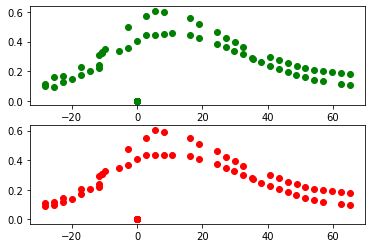

In [ ]:
# plot
# make 1 x 2 figure
fig, (ax1, ax2) = plt.subplots(2, sharey = True)
# fig.suptitle('True vs Decoded Light Curves: ' )#+ str(light_curve_names[num]))

# pred_time = range(len(pred_flux))
# raw_time = range(len(raw_flux))

# plot raw data
idx = 3
# print(test_inp_two[idx, :, 0])
# print(predictions_prepending[idx])
ax1.scatter(test_inp_two_prepended_padding[idx, :, 0], predictions_prepending[idx], color = 'green')
# ax1.set_ylabel('actual')

# plot predicted data
# ax2.set_ylabel('predicted')
ax2.scatter(test_inp_two[idx, :, 0], predictions_appending[idx], color = 'red')

In [ ]:
print(dataset.shape)

(16000, 80, 4)


In [ ]:
predictions_appending = vae.encoder.predict(lc_with_padding.reshape(-1, vae.num_timesteps, 4))[0]
# now, instead of appending, prepend the masking
# print(*lc_with_prepended_padding)
# test_inp_two_with_prepended_padding = lc_with_prepended_padding[:, :, :2]
predictions_prepending = vae.encoder.predict(lc_with_padding.reshape(-1, vae.num_timesteps, 4))[0]

print(predictions_appending)
print(predictions_prepending)
print(predictions_appending-predictions_prepending)


(None, 30)
(None, 30)
2/2 [==============================] - 0s 65ms/step
[[-0.01454129  0.01892478  0.01107807 ... -0.03691708  0.04213447
   0.04782926]
 [-0.01451713  0.01892385  0.01105853 ... -0.03691977  0.04215039
   0.04783317]
 [-0.01453867  0.01892473  0.01107653 ... -0.03691752  0.04213512
   0.0478288 ]
 ...
 [-0.0145373   0.01892511  0.01107504 ... -0.03691813  0.04213579
   0.04782927]
 [-0.013738    0.01916268  0.01068711 ... -0.03669935  0.04233
   0.04752021]
 [-0.01452757  0.01892468  0.01106451 ... -0.03691933  0.04214449
   0.04783417]]
[[-0.01454129  0.01892478  0.01107807 ... -0.03691708  0.04213447
   0.04782926]
 [-0.01451713  0.01892385  0.01105853 ... -0.03691977  0.04215039
   0.04783317]
 [-0.01453867  0.01892473  0.01107653 ... -0.03691752  0.04213512
   0.0478288 ]
 ...
 [-0.0145373   0.01892511  0.01107504 ... -0.03691813  0.04213579
   0.04782927]
 [-0.013738    0.01916268  0.01068711 ... -0.03669935  0.04233
   0.04752021]
 [-0.01452757  0.01892468  0.0

In [ ]:
rvae = VAE(dataset, dataset.shape)
vae = keras.models.load_model(path_to_module + "chck_pts_sim/8_classes/ckpt_11", custom_objects={
    'VAE':VAE, 'Encoder':Encoder, 
    'Decoder':Decoder, 'Sampling':Sampling,
    'reconstruction_loss':rvae.reconstruction_loss})

In [ ]:
vae.summary()
vae.encoder.summary()
# vae.encoder.input_mask.summary()

In [ ]:
print("TEST CUSTOM LAYER")
vae = VAE(dataset, dataset.shape)
lc = np.array([dataset[0]])
# print(lc)
input_two = lc[:, :, :2]
vae.call([lc, input_two])


TEST CUSTOM LAYER


inputs: Tensor("encoder/Cast:0", shape=(1, 80, 4), dtype=float32)
mask: Tensor("encoder/masking/mul:0", shape=(1, 80, 4), dtype=float32)
gru1: Tensor("encoder/gru1/transpose_2:0", shape=(1, 80, 175), dtype=float32)
encoded: Tensor("encoder/gru2/transpose_2:0", shape=(1, 80, 150), dtype=float32)
z_mean: Tensor("encoder/gru3/strided_slice_3:0", shape=(1, 30), dtype=float32)
z_log_var: Tensor("encoder/gru4/strided_slice_3:0", shape=(1, 30), dtype=float32)
(1, 30)
(1, 30)
z: Tensor("encoder/Sampling/add:0", shape=(1, 30), dtype=float32)
repeater: Tensor("decoder/rep/Tile:0", shape=(1, 80, 30), dtype=float32)
concat: Tensor("decoder/concatenate/concat:0", shape=(1, 80, 32), dtype=float32)


ValueError: ignored

In [ ]:
# vae.t_SNE_plot = rvae.t_SNE_plot 
rvae = VAE(dataset, dataset.shape)
vae.t_SNE_plot = rvae.t_SNE_plot
vae.t_SNE_plot(labels)

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
import random
import joblib
from collections import Counter
import tensorflow as tf
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (roc_auc_score, roc_curve, auc, RocCurveDisplay, 
                             PrecisionRecallDisplay, precision_recall_curve, average_precision_score)
from itertools import cycle
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
class RandomForest:

    def __init__(self, labels, prepared_data, encoder):

        # initialize rvae
        self.rvae = VAE(prepared_data, prepared_data.shape)

        # encoded dimension from NN
        self.encoded_dim = self.rvae.latent_dim

        # get training encoder
        self.encoder = encoder

        # augmented data frame
        # self.light_curves = light_curves
        self.labels = labels

        # prepared data
        self.prepared_data = prepared_data
        self.colors = colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red" ,"aquamarine", "crimson", "violet"])
        self.classes = ['Ibc', 'SNIa-x', 'Kilonova', 'II', 'SNIa-norm', 'SNIa-91bg', 'SLSN-I', 'TDE']

    def create_test_train(self):
        """
        Splits data into 85% training, 15% testing, and unlabeled
        """

        print("Splitting data for RF...")

        # extract all class outputs and inputs
        prep_out = self.labels# np.array([c.loc[0, 'Class'] for c in self.light_curves])
        prep_inp = self.prepared_data

        # extract all training label indexes
        train_indx = [i for i in range(len(prep_out)) if prep_out[i] != 3]
        unclassified_indx = [i for i in range(
            len(prep_out)) if prep_out[i] == 3]
        num_indxs = len(train_indx)

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        x_unclassified = []

        # extract training data
        while len(x_train) < int(num_indxs*0.85):
            ran = random.randint(0, len(train_indx)-1)
            ind = train_indx[ran]
            train_indx.remove(ind)
            x_train.append(prep_inp[ind])
            y_train.append(prep_out[ind])

        # append the rest of the data to testing
        for ind in train_indx:
            x_test.append(prep_inp[ind])
            y_test.append(prep_out[ind])

        # extract unclassified data
        for ind in unclassified_indx:
            x_unclassified.append(prep_inp[ind])

        # change to numpy arrays
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_unclassified = np.array(x_unclassified)

        # change y arrays to 1-d arrays
        y_train.shape = (y_train.shape[0],)
        y_test.shape = (y_test.shape[0],)

        print('shape of x_train and x_test:', x_train.shape, x_test.shape)
        print('shape of y_train and y_test:', y_train.shape, y_test.shape)
        print('shape of x_unclassified:', x_unclassified.shape)

        return x_train, x_test, y_train, y_test, x_unclassified

    def make_encodings(self, x_train, x_test, x_unclassified):
        """
        Uses trained encoder to produce 1D encodings of light curves to be used for RF training
        """
        print('making encodings...')

        # encode training light curves
        x_train_enc = self.encoder.predict(
            x_train, workers=32, use_multiprocessing=True, batch_size=128, verbose=1)[2]
        x_test_enc = self.encoder.predict(
            x_test, workers=32, use_multiprocessing=True, batch_size=128, verbose=1)[2]
        if len(x_unclassified) > 0:
          x_unclassified_enc = self.encoder.predict(
              x_unclassified, workers=32, use_multiprocessing=True, batch_size=64, verbose=1)[2]
        else:
          x_unclassified_enc = [[]]
        # x_train_enc = self.encoder.predict_on_batch(x_train)
        # x_test_enc  = self.encoder.predict_on_batch(x_test)
        # x_unclassified_enc = self.encoder.predict_on_batch(x_unclassified)
        
        # numpy arrays
        x_test_enc = np.array(x_test_enc)
        x_train_enc = np.array(x_train_enc)
        x_unclassified_enc = np.array(x_unclassified_enc)

        print('shape of encodings: ', x_train_enc.shape,
              x_test_enc.shape, x_unclassified_enc.shape)

        return x_train_enc, x_test_enc, x_unclassified_enc

    def build_classier(self, x_train, x_test, x_unclassified, y_train, y_test):
        """
        Trains a RF classifier and tests its prediction accuracy
        """
        print('building classifier...')
        rf = RandomForestClassifier(n_estimators=1000, class_weight = 'balanced')#, min_samples_split=40 )

        # reshape
        x_train = x_train.reshape(-1, self.encoded_dim)
        x_test = x_test.reshape(-1, self.encoded_dim)
        x_unclassified = x_unclassified.reshape(-1, self.encoded_dim)


        print('shape of encodings: ', x_train.shape,
              x_test.shape, x_unclassified.shape)

        # fit to data
        rf.fit(x_train, y_train)
        
        # performing predictions on the test dataset
        number_to_class = {0:'SNIa', 1:'SNIbc', 2:'SNIi', 3:'Unclassified', 4:'Other'}
        y_pred = rf.predict(x_test)

        y_train_counter = {key:value for (key, value) in Counter(y_train).items()}
        y_test_counter = {key:value for (key, value) in Counter(y_test).items()}
        y_pred_counter = {key:value for (key, value) in Counter(y_pred).items()}
        print('y_train counts: ', y_train_counter)
        print('y_test counts: ', y_test_counter)
        print('y_pred counts: ', y_pred_counter)

        # check accuracy
        print("ACCURACY OF THE MODEl: ", 100 *
              round(rf.score(x_test, y_test), 2), '%')

       # Create confusion matrix
        conf_mat = pd.crosstab(y_test, y_pred, rownames=[
                               'Actual Species'], colnames=['Predicted Species'])

        print('Confusion Matrix:')
        print(conf_mat.to_string())

        fig, ax = plt.subplots(figsize=(12, 12))
        self.plot_confusion_matrix(x_test, y_test, rf)
        # plot_confusion_matrix(
        #     rf, 
        #     x_test, 
        #     y_test, 
        #     display_labels = ['Ibc', 'SNIa-x', 'Kilonova', 'II', 'SNIa-norm', 'SNIa-91bg', 'SLSN-I', 'TDE'], 
        #     ax=ax)
        plt.show()

        # print('Unlabeled Classifications: ')
        # unlabeled = rf.predict(x_unclassified)
        # print(unlabeled)
        # print(Counter(unlabeled))

        return rf
        
    def plot_confusion_matrix(self, x_test, y_test, classifier):
        np.set_printoptions(precision=2)
        # Plot non-normalized confusion matrix
        titles_options = [
            ("Confusion matrix, without normalization", None),
            ("Normalized confusion matrix", "true"),
        ]
        for title, normalize in titles_options:
            disp = ConfusionMatrixDisplay.from_estimator(
                classifier,
                x_test,
                y_test,
                display_labels=self.classes,
                cmap=plt.cm.Blues,
                normalize=normalize,
            )
            disp.ax_.set_title(title)
            disp.figure_.set_size_inches(18.5, 10.5, forward=True)
            

            print(title)
            print(disp.confusion_matrix)
        
        
        plt.show()

    def plot_roc_curve(self, y_train, x_test_enc, y_test, classifier):
        n_classes = len(self.classes)
        # make one-hot encodings for one-vs-all ROC curves
        label_binarizer = LabelBinarizer().fit(y_train)
        y_onehot_test = label_binarizer.transform(y_test)
        print(y_onehot_test.shape)  # (n_samples, n_classes)
        y_score = classifier.predict_proba(x_test_enc)
        print(y_score.shape)

        # store the fpr, tpr, and roc_auc for all averaging strategies
        fpr, tpr, roc_auc = dict(), dict(), dict()
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr_grid = np.linspace(0.0, 1.0, 1000)

        # Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(n_classes):
            mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

        # Average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = fpr_grid
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

        fig, ax = plt.subplots(figsize=(12, 12))

        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
            color="navy",
            linestyle=":",
            linewidth=4,
        )

        for class_id, color in zip(range(len(self.classes)), self.colors):
            RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_score[:, class_id],
                name=f"ROC curve for {self.classes[class_id]}",
                color=color,
                ax=ax,
            )

        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
        plt.legend()
        plt.show()

    def plot_precision_recall_curve(self, x_test_enc, y_test, y_train, classifier):
        n_classes = len(self.classes)

        # make one-hot encodings
        label_binarizer = LabelBinarizer().fit(y_train)
        y_onehot_test   = label_binarizer.transform(y_test)
        y_score          = classifier.predict_proba(x_test_enc)

        # For each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_onehot_test.ravel(), y_score.ravel()
        )
        average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

        # plot all precision recall curves
        _, ax = plt.subplots(figsize=(7, 8))

        f_scores = np.linspace(0.2, 0.8, num=4)
        lines, labels = [], []
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
            plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

        display = PrecisionRecallDisplay(
            recall=recall["micro"],
            precision=precision["micro"],
            average_precision=average_precision["micro"],
        )
        display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
        
        for i, color in zip(range(n_classes), self.colors):
            display = PrecisionRecallDisplay(
                recall=recall[i],
                precision=precision[i],
                average_precision=average_precision[i],
            )
            display.plot(ax=ax, name=f"Precision-recall for class {self.classes[i]}", color=color)

        # add the legend for the iso-f1 curves
        handles, labels = display.ax_.get_legend_handles_labels()
        handles.extend([l])
        labels.extend(["iso-f1 curves"])
        # set the legend and the axes
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.legend(handles=handles, labels=labels, loc="best")
        ax.set_title("Extension of Precision-Recall curve to multi-class")

        plt.show()

# %%

Splitting data for RF...
shape of x_train and x_test: (13600, 80, 4) (2400, 80, 4)
shape of y_train and y_test: (13600,) (2400,)
shape of x_unclassified: (0,)
making encodings...
19/19 [==============================] - 2s 86ms/step
shape of encodings:  (13600, 30) (2400, 30) (1, 0)
building classifier...
shape of encodings:  (13600, 30) (2400, 30) (0, 30)
y_train counts:  {'SNIa-91bg': 1686, 'SNIa-norm': 1697, 'Kilonova': 1702, 'SNIa-x': 1693, 'II': 1727, 'TDE': 1689, 'Ibc': 1711, 'SLSN-I': 1695}
y_test counts:  {'II': 273, 'Ibc': 289, 'Kilonova': 298, 'SLSN-I': 305, 'SNIa-91bg': 314, 'SNIa-norm': 303, 'SNIa-x': 307, 'TDE': 311}
y_pred counts:  {'Kilonova': 314, 'TDE': 291, 'II': 332, 'SNIa-91bg': 295, 'SLSN-I': 285, 'SNIa-norm': 271, 'SNIa-x': 300, 'Ibc': 312}
ACCURACY OF THE MODEl:  14.000000000000002 %
Confusion Matrix:
Predicted Species  II  Ibc  Kilonova  SLSN-I  SNIa-91bg  SNIa-norm  SNIa-x  TDE
Actual Species                                                                 
II  

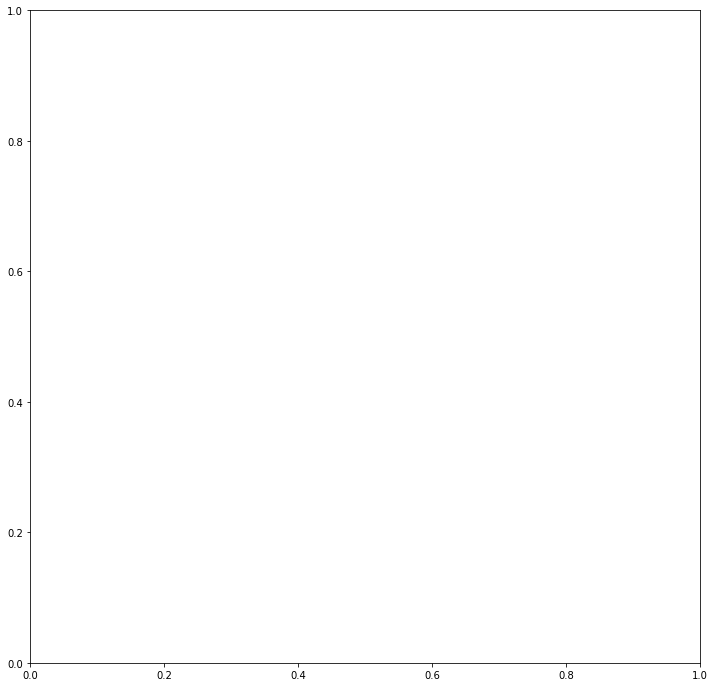

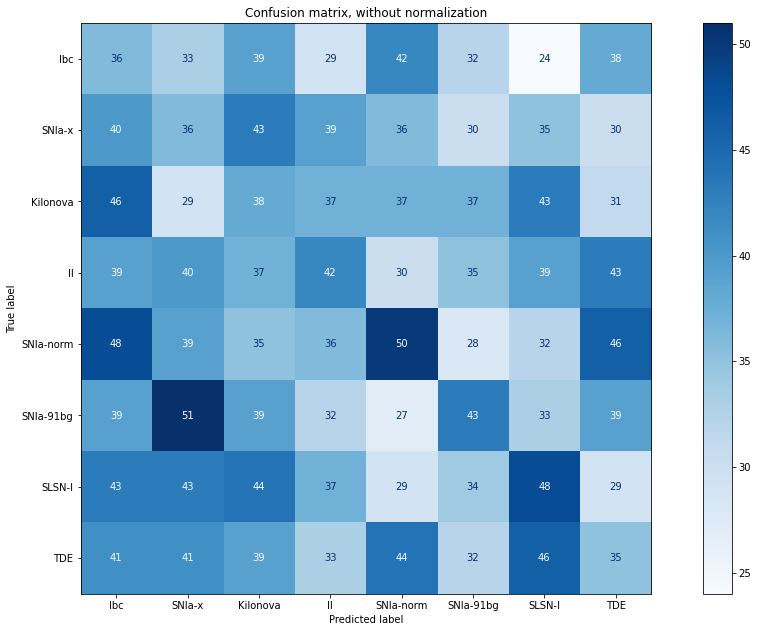

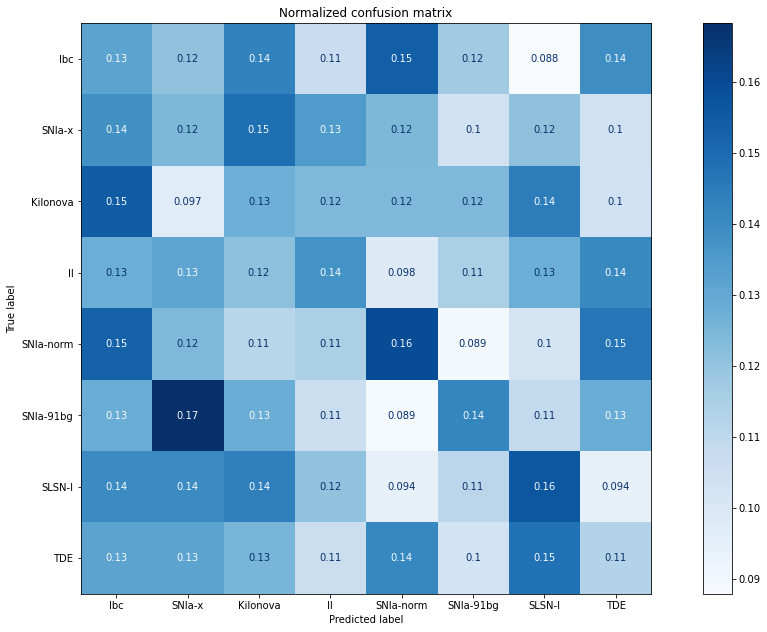

In [ ]:
rf= RandomForest(labels,dataset, vae.encoder)


# split data set for supervised training
x_train, x_test, y_train, y_test, x_unclassified= rf.create_test_train()
# print(x_train)
# encode input data
x_train_enc,x_test_enc,x_unclassified_enc=rf.make_encodings(x_train, x_test, x_unclassified)

# build and train the classifier
classifier = rf.build_classier(x_train_enc,x_test_enc,x_unclassified_enc,y_train,y_test)



Confusion matrix, without normalization
[[163  24   0  29  13  15  46  18]
 [ 14 126   7  17  53  51  25   7]
 [  0   0 292   0   8   0   1   0]
 [ 27   5   0 140   1  10  35  74]
 [  1   9   7   0 286  12  15   1]
 [ 12  29   1   9  35 111  76   5]
 [ 21  21   0  11  13  69 139  13]
 [ 13   2   0  39   0   1   3 245]]
Normalized confusion matrix
[[0.53 0.08 0.   0.09 0.04 0.05 0.15 0.06]
 [0.05 0.42 0.02 0.06 0.18 0.17 0.08 0.02]
 [0.   0.   0.97 0.   0.03 0.   0.   0.  ]
 [0.09 0.02 0.   0.48 0.   0.03 0.12 0.25]
 [0.   0.03 0.02 0.   0.86 0.04 0.05 0.  ]
 [0.04 0.1  0.   0.03 0.13 0.4  0.27 0.02]
 [0.07 0.07 0.   0.04 0.05 0.24 0.48 0.05]
 [0.04 0.01 0.   0.13 0.   0.   0.01 0.81]]


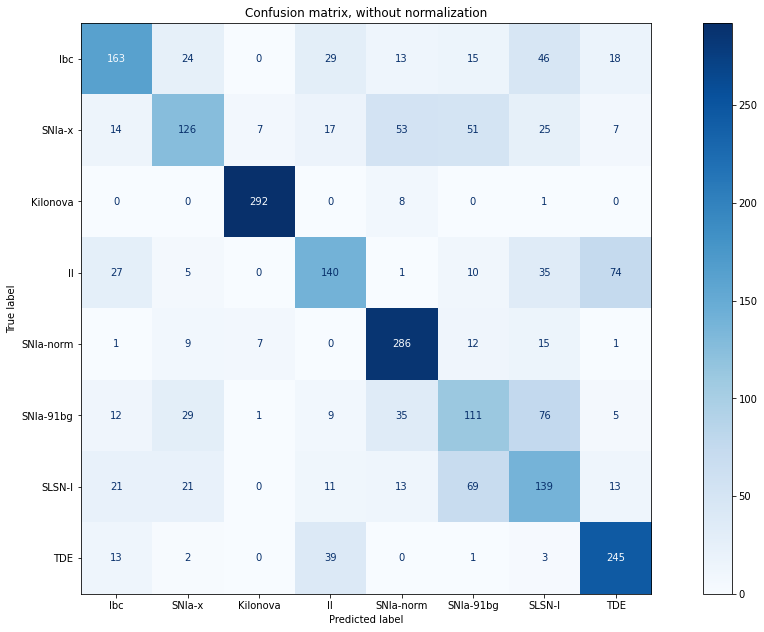

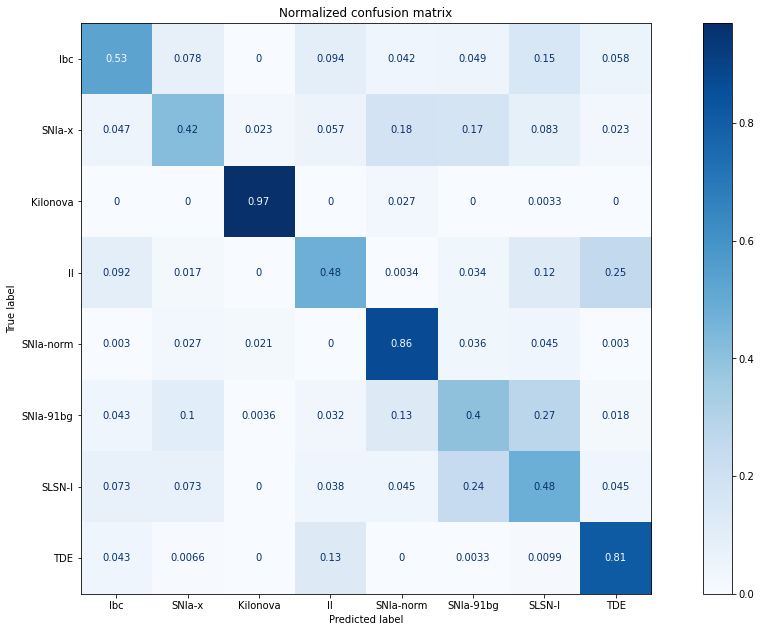

In [ ]:
# rf_ex = RandomForest(labels, dataset, vae.encoder)
# rf.plot_confusion_matrix = rf_ex.plot_confusion_matrix
rf.plot_confusion_matrix(x_test_enc,y_test, classifier)

(2400, 8)
(2400, 8)
Micro-averaged One-vs-Rest ROC AUC score:
0.93
Macro-averaged One-vs-Rest ROC AUC score:
0.91


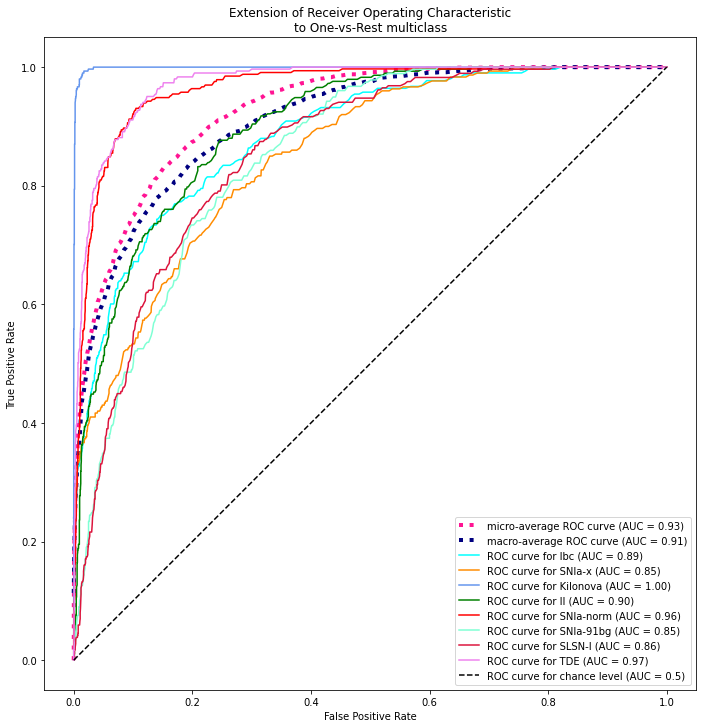

In [ ]:
rf_new = RandomForest(labels, dataset, vae.encoder)
rf.plot_roc_curve = rf_new.plot_roc_curve
rf.plot_roc_curve(y_train, x_test_enc, y_test, classifier)

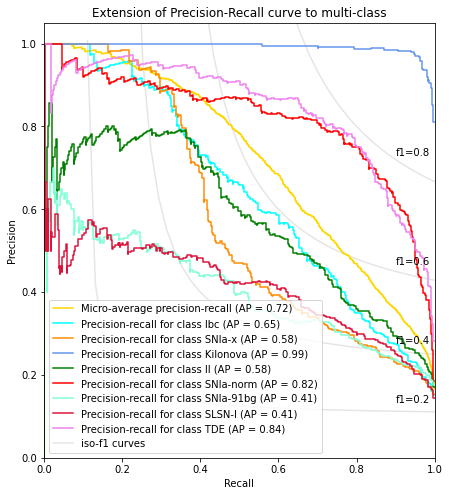

In [ ]:
rf.plot_precision_recall_curve = rf_new.plot_precision_recall_curve
rf.plot_precision_recall_curve(x_test_enc, y_test, y_train, classifier)

In [ ]:
indexes=[0, 4000]
for i in indexes:
  correct = labels[i]
  # shape should be (1, 300, 4)
  light_curve = np.array([dataset[i]])
  encoded_lc = rf.encoder.predict(light_curve)[2]
  # make prediction from data
  pred = classifier.predict(encoded_lc)
  # make class num -> classification dict
  classes = {0: 'SNIa', 1: 'SNIbc', 2: 'SNII',
              3: 'Other', 4: 'Unclassified'}

  # print confidence
  probs = np.array(classifier.predict_proba(encoded_lc)[0])
  print('Number of different possible predictions: ', len(probs))
  highest_prob_ind = np.argmax(probs)
  highest_prob = probs[highest_prob_ind]
  print("Probabilities:", probs)
  print('Prediction is ' + classes[highest_prob_ind]+' (',
        pred[0], ') with '+str(int(highest_prob*100))+'% confidence')
  print('Correct classification should be: ',
        classes[correct], ' (', correct, ')')
  print()